In [1]:
using OrdinaryDiffEq
using Turing
using LinearAlgebra
using QuadGK
using Plots, StatsPlots, LaTeXStrings
using DelimitedFiles, DataFrames, CategoricalArrays

In [2]:
figdir = "figures/";

## Data



In [3]:
# load data
filename = "../../data/AHS/Restricted/analysis.csv"
data, header = readdlm(filename, ',', header=true)
df = DataFrame(data, vec(header))
# data types
df = identity.(df) # auto identify the data type
df."Age group" = categorical(df."Age group", ordered=true)
levels!(df."Age group", ["Under 1 year", "1-4 years", "5-9 years", "10-19 years", "20-29 years", 
        "30-39 years", "40-49 years", "50-59 years", "60-69 years", "70-79 years", "80+ years"])

5881-element CategoricalArray{String,1,UInt32}:
 "80+ years"
 "50-59 years"
 "70-79 years"
 "70-79 years"
 "60-69 years"
 "80+ years"
 "50-59 years"
 "50-59 years"
 "60-69 years"
 "60-69 years"
 "70-79 years"
 "70-79 years"
 "50-59 years"
 ⋮
 "80+ years"
 "80+ years"
 "70-79 years"
 "50-59 years"
 "70-79 years"
 "20-29 years"
 "20-29 years"
 "80+ years"
 "70-79 years"
 "Under 1 year"
 "70-79 years"
 "60-69 years"

In [6]:
df2 = df[:, ["Disch_days", "Dead", "Age group"]]
rename!(df2, :Disch_days => :time, :Dead => :dead, Symbol("Age group") => :group)#, Symbol("Age group") => :age_group)
# prepare data
transform!(df2, :time => ByRow(x -> Float64(-x)) => :time, 
                :dead => ByRow(x -> x == "True" ? 1.0 : 0.0) => :dead,
#                 :sex => ByRow(x -> x == "Female" ? 1 : 2) => :sex,
                :group => ByRow(x -> x <= CategoricalValue("40-49 years", df2.group) ? 1 : 
                                   x <= CategoricalValue("60-69 years", df2.group) ? 2 : 3) => :group)
describe(df2)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,time,17.9129,0.0,12.0,268.0,0,Float64
2,dead,0.200986,0.0,0.0,1.0,0,Float64
3,group,2.185,1,2.0,3,0,Int64


In [7]:
groups = select(df2, Not([:time, :dead]))
for col in eachcol(groups)
    println(sort(unique(col)))
end

[1, 2, 3]


## Standard virus load function

The standard virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

In [8]:
H(x) = 0.5*(tanh(1e3*x) + 1.)
v₁(t, a₁, a₂, Vmax) = 1. + (Vmax - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/(a₂ - a₁)))/2
v₂(t, a₂, α) = 1 - H(t - a₂) + H(t - a₂)*exp(-α*(t - a₂))
v₃(t, b₁, b₂, Vmin) = 1 - (1.0 - Vmin)*(tanh(6.0*(t - (b₁ + b₂)/2)/(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/(b₂ - b₁)))/2
function VLF(t, p)
    a₁, a₂, b₁, b₂, α, Vmax, Vmin = p
    v₁(t, a₁, a₂, Vmax)*v₂(t, a₂, α)*v₃(t, b₁, b₂, Vmin)
end

VLF (generic function with 1 method)

## ODE model for COVID-19

This model includes the fraction of healthy cells in the lung epithilium $E$, which are infected by free virons $V$, and release cytokines $C$ when infected. Immune cells $X_1$ are estimulated by cytokines levels, and can become infected $X_2$ by free virons. 

$$
\begin{aligned}
    \frac{d E}{dt} & = \mu_E E(1-E) - \delta_E E \frac{V}{V_{max}}\\
    \frac{d C}{dt} & = \mu_C(M_C - C) + \gamma_C V(t) (1 - E) \\
    \frac{d X_1}{dt} & = \alpha_X C X_1 - \gamma_X \frac{V(t)}{V_{max}} X_1 - β_1 X_1 \\
    \frac{d X_2}{dt} & = \gamma_X \frac{V(t)}{V_{max}} X_1 - \beta_2 X_2 \\
\end{aligned}
$$ 

Model

In [9]:
function ModelODE!(du, u, p, t)
    E, C, X₁, X₂ = u
    a₁, a₂, b₁, b₂, α, Vmax, Vmin, μ_E, δ_E, μ_C, M_C, γ_C, α_X, γ_X, β₁, β₂, E_θ = p
    V(t) = VLF(t, [a₁, a₂, b₁, b₂, α, Vmax, Vmin])
    # Lung damage
    du[1] = dE = μ_E*E*(1.0 - E) - δ_E*E*V(t)/Vmax # Healthy lung epithelium
    du[2] = dC = μ_C*(M_C - C) + γ_C*V(t)*(1 - E)
    du[3] = dX₁ = α_X*C*X₁ - γ_X*V(t)/Vmax*X₁ - β₁*X₁
    du[4] = dX₂ = γ_X*V(t)/Vmax*X₁ - β₂*X₂
end
u_labels = ["Healthy lung cells" "Cytokines" "Healthy mmune cells" "Infected immune cells"]
p_labels = [:a₁, :a₂, :b₁, :b₂, :α, :Vmax, :Vmin, :μ_E, :δ_E, :μ_C, :M_C, :γ_C, :α_X, :γ_X, :β₁, :β₂, :E_θ];

Initial conditions and parameter values

In [10]:
# initial
u0 = [
    1.0   #E: Healthy lung epithilium
    0.001 #C: Cytokines promoters
    2.0   #X₁: Immune cells
    0.0   #X₂: Infected immune cells
]
tspan = (0.0, 40.0)
pars = [
    0.5     # a₁
    4.0     # a₂
    13.0    # b₁
    19.0    # b₂
    0.1     # α
    3.7e3    # Vmax
    1e-8    # Vmin
    0.01    # μ_E 
    0.15    # δ_E (x3) changed from notes to accommodate true V/Vmax and produce the same graph
    0.5     # μ_C
    0.1     # M_C
    0.01    # γ_C
    0.01    # α_X
    0.000001   # γ_X (x1e-3) changed from notes to accommodate true V/Vmax and produce the same graph
    0.00001    # β₁ (x1e-3) changed from notes to accommodate true V/Vmax and produce the same graph
    0.5     # β₂
    0.3     # E_θ
    ]
pars_nt = (; zip(p_labels, pars)...)
prob = ODEProblem(ModelODE!, u0, tspan, pars);

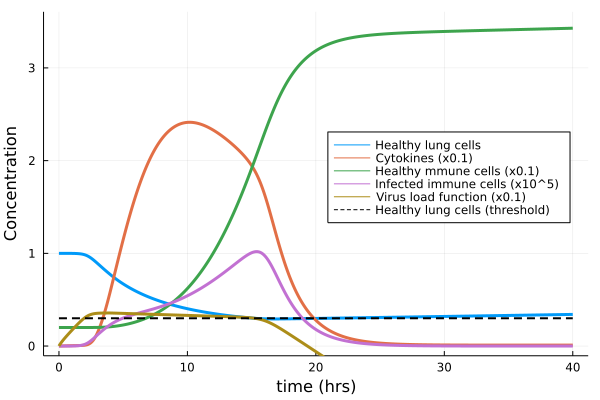

In [11]:
prob = remake(prob, p=pars)
sol = solve(prob, Tsit5(), dtmax=1e-1)
pt = plot(sol.t, sol[1, :], lw=3, labels=u_labels[1])
plot!(pt, sol.t, 1e-1sol[2, :], lw=3, labels=u_labels[2]*" (x0.1)")
plot!(pt, sol.t, 1e-1sol[3, :], lw=3, labels=u_labels[3]*" (x0.1)")
plot!(pt, sol.t, 1e5sol[4, :], lw=3, labels=u_labels[4]*" (x10^5)")
plot!(pt, sol.t, t->1e-1log10(VLF(t, pars[1:7])), lw=3, labels="Virus load function"*" (x0.1)")
plot!(pt, sol.t, fill(pars_nt.E_θ, length(sol.t)), line=(2, :dash, :black), color=1, labels=u_labels[1]*" (threshold)")
plot!(pt, xaxis=("time (hrs)"), yaxis=("Concentration", [0, 3.5]), legend=:right)

**Comments:**

- Lung cells should be separated into healthy and infected.
- Estiimulation of the immune response by cytokines should not require active inmune response.
- Why normalized viral load $V/Vmax$?

## Probabilistic model


In [12]:
function ModelODE!(du, u, p, t)
    E, C, X₁, X₂ = u
    a₁, a₂, b₁, b₂, α, Vmax, Vmin, μ_E, δ_E, μ_C, M_C, γ_C, α_X, γ_X, β₁, β₂, E_θ = p
    V(t) = VLF(t, [a₁, a₂, b₁, b₂, α, Vmax, Vmin])
    # Lung damage
    du[1] = dE = μ_E*E*(1.0 - E) - δ_E*E*V(t)/Vmax # Healthy lung epithelium
    du[2] = dC = μ_C*(M_C - C) + γ_C*V(t)*(1 - E)
    du[3] = dX₁ = α_X*C*X₁ - γ_X*V(t)/Vmax*X₁ - β₁*X₁
    du[4] = dX₂ = γ_X*V(t)/Vmax*X₁ - β₂*X₂
end
u_labels = ["Healthy lung cells" "Cytokines" "Healthy mmune cells" "Infected immune cells"]
p_labels = [:a₁, :a₂, :b₁, :b₂, :α, :Vmax, :Vmin, :μ_E, :δ_E, :μ_C, :M_C, :γ_C, :α_X, :γ_X, :β₁, :β₂, :E_θ];

In [13]:
# initial
u0 = [
    1.0   #E: Healthy lung epithilium
    0.001 #C: Cytokines promoters
    2.0   #X₁: Immune cells
    0.0   #X₂: Infected immune cells
]
tspan = (0.0, 40.0)
pars = [
    0.5     # a₁
    4.0     # a₂
    13.0    # b₁
    19.0    # b₂
    0.1     # α
    3.7e3    # Vmax
    1e-8    # Vmin
    0.01    # μ_E 
    0.15    # δ_E (x3) changed from notes to accommodate true V/Vmax and produce the same graph
    0.5     # μ_C
    0.1     # M_C
    0.01    # γ_C
    0.01    # α_X
    0.000001   # γ_X (x1e-3) changed from notes to accommodate true V/Vmax and produce the same graph
    0.00001    # β₁ (x1e-3) changed from notes to accommodate true V/Vmax and produce the same graph
    0.5     # β₂
    0.3     # E_θ
    ]
pars_nt = (; zip(p_labels, pars)...)
prob = ODEProblem(ModelODE!, u0, tspan, pars);

In [14]:
@model function ModelProb(data, prob, covars)
    # data: (time, dead_flag, group)
    # group: value 1 to K_groups 
    # covars: indexes in prob.u of covariates eg. [1, ]
    
    # groups
    K_groups = length(unique(data.group))
    
    # ODE parameters (default)
    a₁, a₂, b₁, b₂, α, Vmax, Vmin, μ_E, δ_E, μ_C, M_C, γ_C, α_X, γ_X, β₁, β₂, E_θ = prob.p
    
    # priors
    #Vmax ~ Normal(3.7e3, 10.)
    μ_E = rand(Normal(μ_E, 0.0001), K_groups)
    λ ~ filldist(Exponential(1.0), K_groups)
    
    # ODE parameters (default + random sample)
    η = fill(Array{Float64}(undef, length(prob.p)), K_groups)
    for k in 1:K_groups
        η[k] = [a₁, a₂, b₁, b₂, α, Vmax, Vmin, μ_E[k], δ_E, μ_C, M_C, γ_C, α_X, γ_X, β₁, β₂, E_θ]
    end
    
    # Covariate parameters
    N_covars = length(covars)
    μ_β = fill(0., N_covars)
    Σ_β = 0.1*I
    β ~ MvNormal(μ_β, Σ_β)
    
    # iterate for each patient
    for row in eachrow(data)
        t_s = rand(Normal(5.0, 0.1))
        # ODE
        prob = remake(prob, p=η[row.group], tspan=(0.0, t_s + row.time))
        sol = solve(prob, Tsit5(), dtmax=1e-1)
        # Survival
        x(t) = sol(t)[covars, :] .- η[row.group][end]
        h(t) = λ[row.group]*exp(-dot(x(t), β))
        H(t) = quadgk(h, 0., t)
        # Log-likelihood
        logL(t, d) = sum(d.*log(h(t)) .- H(t))
        Turing.@addlogprob! logL(t_s + row.time, row.dead)
    end
end

ModelProb (generic function with 1 method)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/shigoto/.julia/packages/Turing/y0DW3/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:12


Chains MCMC chain (100×16×1 Array{Float64, 3}):

Iterations        = 51:1:150
Number of chains  = 1
Samples per chain = 100
Wall duration     = 97.05 seconds
Compute duration  = 97.05 seconds
parameters        = λ[2], λ[1], λ[3], β[1]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Missing    Float64   Float64     ⋯

        λ[1]    0.0068    0.0087     0.0009   missing    25.5176    1.0006     ⋯
        λ[2]    0.0244    0.0066     0.0007   missing   111.4945    0.9923     ⋯
        λ[3]    0.0362    0.0103     0.0010   missing   170.5970    0.9934     ⋯
        β[1]    0.4375    0.3082     0.0308   missing   168.3073    0.9907     ⋯
                                                      

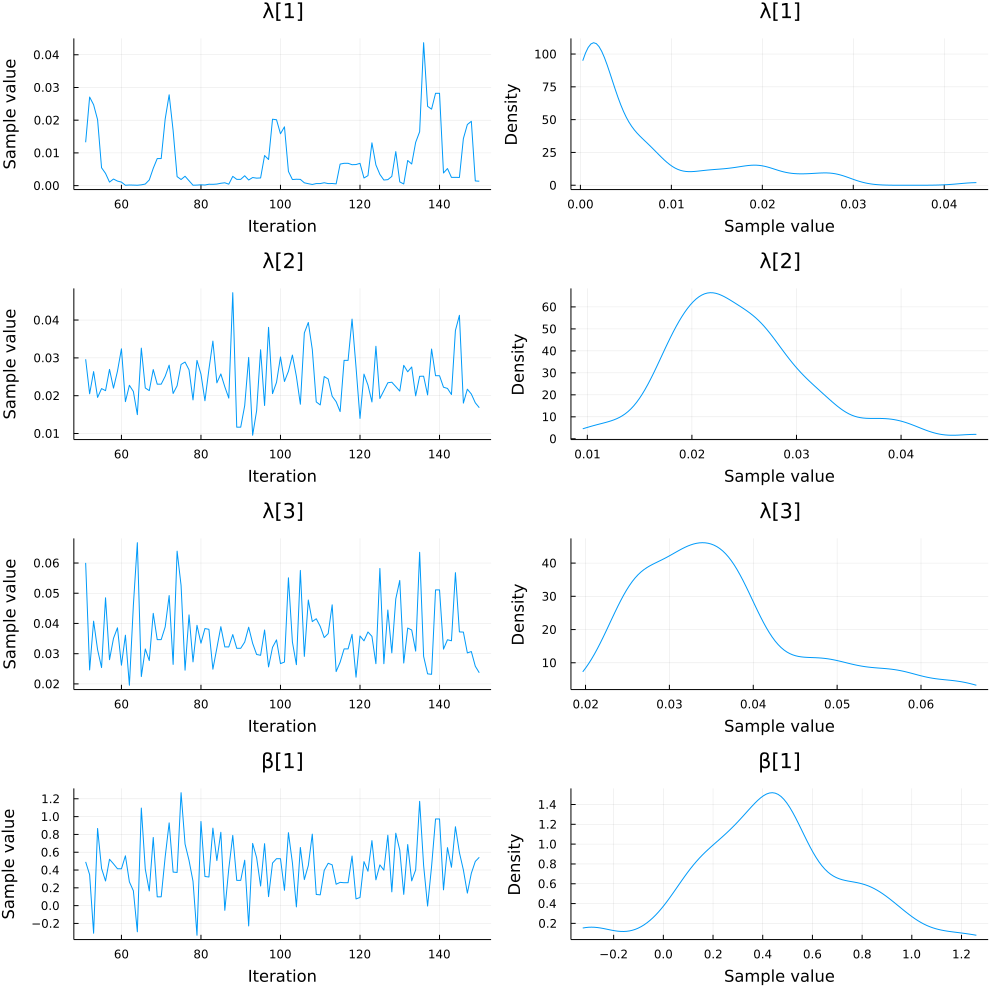

In [15]:
Model = ModelProb(df2[1:50, :], prob, [1, ])
chn = sample(Model, NUTS(), 100)
display(chn)
plot(chn)

In [16]:
function ModelODE!(du, u, p, t)
    E, C, X₁, X₂ = u
    a₁, a₂, b₁, b₂, α, Vmax, Vmin, μ_E, δ_E, μ_C, M_C, γ_C, α_X, γ_X, β₁, β₂, E_θ = p
    V(t) = VLF(t, [a₁, a₂, b₁, b₂, α, Vmax, Vmin])
    # Lung damage
    du[1] = dE = μ_E*E*(1.0 - E) - δ_E*E*V(t)/Vmax # Healthy lung epithelium
    du[2] = dC = μ_C*(M_C - C) + γ_C*V(t)*(1 - E)
    du[3] = dX₁ = α_X*C*X₁ - γ_X*V(t)/Vmax*X₁ - β₁*X₁
    du[4] = dX₂ = γ_X*V(t)/Vmax*X₁ - β₂*X₂
end
u_labels = ["Healthy lung cells" "Cytokines" "Healthy mmune cells" "Infected immune cells"]
p_labels = [:a₁, :a₂, :b₁, :b₂, :α, :Vmax, :Vmin, :μ_E, :δ_E, :μ_C, :M_C, :γ_C, :α_X, :γ_X, :β₁, :β₂, :E_θ];

In [17]:
# initial
u0 = [
    1.0   #E: Healthy lung epithilium
    0.001 #C: Cytokines promoters
    2.0   #X₁: Immune cells
    0.0   #X₂: Infected immune cells
]
tspan = (0.0, 40.0)
pars = [
    0.5     # a₁
    4.0     # a₂
    13.0    # b₁
    19.0    # b₂
    0.1     # α
    3.7e3    # Vmax
    1e-8    # Vmin
    0.01    # μ_E 
    0.15    # δ_E (x3) changed from notes to accommodate true V/Vmax and produce the same graph
    0.5     # μ_C
    0.1     # M_C
    0.01    # γ_C
    0.01    # α_X
    0.000001   # γ_X (x1e-3) changed from notes to accommodate true V/Vmax and produce the same graph
    0.00001    # β₁ (x1e-3) changed from notes to accommodate true V/Vmax and produce the same graph
    0.5     # β₂
    0.3     # E_θ
    ]
pars_nt = (; zip(p_labels, pars)...)
prob = ODEProblem(ModelODE!, u0, tspan, pars);

In [18]:
@model function ModelProb(data, prob, covars)
    # data: (time, dead_flag, group)
    # group: value 1 to K_groups 
    # covars: indexes in prob.u of covariates eg. [1, ]
    
    # groups
    K_groups = length(unique(data.group))
    
    # ODE parameters (default)
    a₁, a₂, b₁, b₂, α, Vmax, Vmin, μ_E, δ_E, μ_C, M_C, γ_C, α_X, γ_X, β₁, β₂, E_θ = prob.p
    
    # priors
    #Vmax ~ Normal(3.7e3, 10.)
    μ_E ~ filldist(Normal(μ_E, 0.0001), K_groups)
    λ ~ filldist(Exponential(1.0), K_groups)
    
    # ODE parameters (default + random variables)
    η = fill(Array{Float64}(undef, length(prob.p)), K_groups)
    for k in 1:K_groups
        η[k] = [a₁, a₂, b₁, b₂, α, Vmax, Vmin, μ_E[k], δ_E, μ_C, M_C, γ_C, α_X, γ_X, β₁, β₂, E_θ]
    end
    
    # Covariate parameters
    N_covars = length(covars)
    μ_β = fill(0., N_covars)
    Σ_β = 0.1*I
    β ~ MvNormal(μ_β, Σ_β)
    
    # iterate for each patient
    for row in eachrow(data)
        t_s = rand(Normal(5.0, 0.1))
        # ODE
#         prob = remake(prob, p=η[row.group], tspan=(0.0, t_s + row.time))
        prob = ODEProblem(ModelODE!, u0, (0.0, t_s + row.time), η[row.group]);
        sol = solve(prob, Tsit5(), dtmax=1e-1)
        # Survival
        x(t) = sol(t)[covars, :] .- η[row.group][end]
        h(t) = λ[row.group]*exp(-dot(x(t), β))
        H(t) = quadgk(h, 0., t)
        # Log-likelihood
        logL(t, d) = sum(d.*log(h(t)) .- H(t))
        Turing.@addlogprob! logL(t_s + row.time, row.dead)
    end
end

ModelProb (generic function with 1 method)

In [19]:
Model = ModelProb(df2[1:50, :], prob, [1, ])
chn = sample(Model, NUTS(), 100)
display(chn)
plot(chn)

LoadError: TypeError: in typeassert, expected Float64, got a value of type ForwardDiff.Dual{Nothing, Float64, 7}

Doing `μ_E ~` and then `η[k]` doesn't work, I get issues with ForwardDiff. I'm trying the model with only random variables.

In [221]:
function ModelODE!(du, u, p, t)
    E, C, X₁, X₂ = u
    pars = [
        0.5     # a₁
        4.0     # a₂
        13.0    # b₁
        19.0    # b₂
        0.1     # α
        3.7e3    # Vmax
        1e-8    # Vmin
        0.01    # μ_E 
        0.15    # δ_E (x3) changed from notes to accommodate true V/Vmax and produce the same graph
        0.5     # μ_C
        0.1     # M_C
        0.01    # γ_C
        0.01    # α_X
        0.000001   # γ_X (x1e-3) changed from notes to accommodate true V/Vmax and produce the same graph
        0.00001    # β₁ (x1e-3) changed from notes to accommodate true V/Vmax and produce the same graph
        0.5     # β₂
        0.3
    ]
    a₁, a₂, b₁, b₂, α, Vmax, Vmin, _, δ_E, μ_C, M_C, γ_C, α_X, γ_X, β₁, β₂, E_θ = pars
    μ_E, = p
    V(t) = VLF(t, [a₁, a₂, b₁, b₂, α, Vmax, Vmin])
    # Lung damage
    du[1] = dE = μ_E*E*(1.0 - E) - δ_E*E*V(t)/Vmax # Healthy lung epithelium
    du[2] = dC = μ_C*(M_C - C) + γ_C*V(t)*(1 - E)
    du[3] = dX₁ = α_X*C*X₁ - γ_X*V(t)/Vmax*X₁ - β₁*X₁
    du[4] = dX₂ = γ_X*V(t)/Vmax*X₁ - β₂*X₂
end
u_labels = ["Healthy lung cells" "Cytokines" "Healthy mmune cells" "Infected immune cells"]
p_labels = [:μ_E, ];
u0 = [
    1.0   #E: Healthy lung epithilium
    0.001 #C: Cytokines promoters
    2.0   #X₁: Immune cells
    0.0   #X₂: Infected immune cells
]
tspan = (0.0, 40.0)
pars = [
    0.01    # μ_E 
    ]
pars_nt = (; zip(p_labels, pars)...)
prob = ODEProblem(ModelODE!, u0, tspan, pars);

In [222]:
@model function ModelProb(data, prob, covars)
    # data: (time, dead_flag, group)
    # group: value 1 to K_groups 
    # covars: indexes in prob.u of covariates eg. [1, ]
    
    # groups
    K_groups = length(unique(data.group))
    
    # priors
    #Vmax ~ Normal(3.7e3, 10.)
    η ~ filldist(Normal(prob.p[1], 0.0001), K_groups)
    λ ~ filldist(Exponential(1.0), K_groups)
    
    # ODE parameters (default + random variables)
#     η = fill(Array{Float64}(undef, length(prob.p)), K_groups)
#     for k in 1:K_groups
#         η[k] = [a₁, a₂, b₁, b₂, α, Vmax, Vmin, μ_E[k], δ_E, μ_C, M_C, γ_C, α_X, γ_X, β₁, β₂, E_θ]
#     end
    
    # Covariate parameters
    N_covars = length(covars)
    μ_β = fill(0., N_covars)
    Σ_β = 0.1*I
    β ~ MvNormal(μ_β, Σ_β)
    
    # iterate for each patient
    for row in eachrow(data)
        t_s = rand(Normal(5.0, 0.1))
        # ODE
        prob = remake(prob, p=η[row.group], tspan=(0.0, t_s + row.time))
        sol = solve(prob, Tsit5(), dtmax=1e-1)
        # Survival
        x(t) = sol(t)[covars, :] .- η[row.group][end]
        h(t) = λ[row.group]*exp(-dot(x(t), β))
        H(t) = quadgk(h, 0., t)
        # Log-likelihood
        logL(t, d) = sum(d.*log(h(t)) .- H(t))
        Turing.@addlogprob! logL(t_s + row.time, row.dead)
    end
end

ModelProb (generic function with 1 method)

┌ Info: Found initial step size
│   ϵ = 1.8310546875000003e-5
└ @ Turing.Inference /home/shigoto/.julia/packages/Turing/y0DW3/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 2:28:32


Chains MCMC chain (100×19×1 Array{Float64, 3}):

Iterations        = 51:1:150
Number of chains  = 1
Samples per chain = 100
Wall duration     = 9007.92 seconds
Compute duration  = 9007.92 seconds
parameters        = λ[2], η[1], η[3], λ[1], λ[3], η[2], β[1]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Missing    Float64   Float64     ⋯

        η[1]    0.0100    0.0001     0.0000   missing   107.8445    1.0008     ⋯
        η[2]    0.0100    0.0001     0.0000   missing   111.8918    1.0008     ⋯
        η[3]    0.0100    0.0001     0.0000   missing    49.2890    1.0331     ⋯
        λ[1]    0.2684    0.1661     0.0166   missing     1.2575    2.2806     ⋯
        λ[2]    0.1229    0.0298

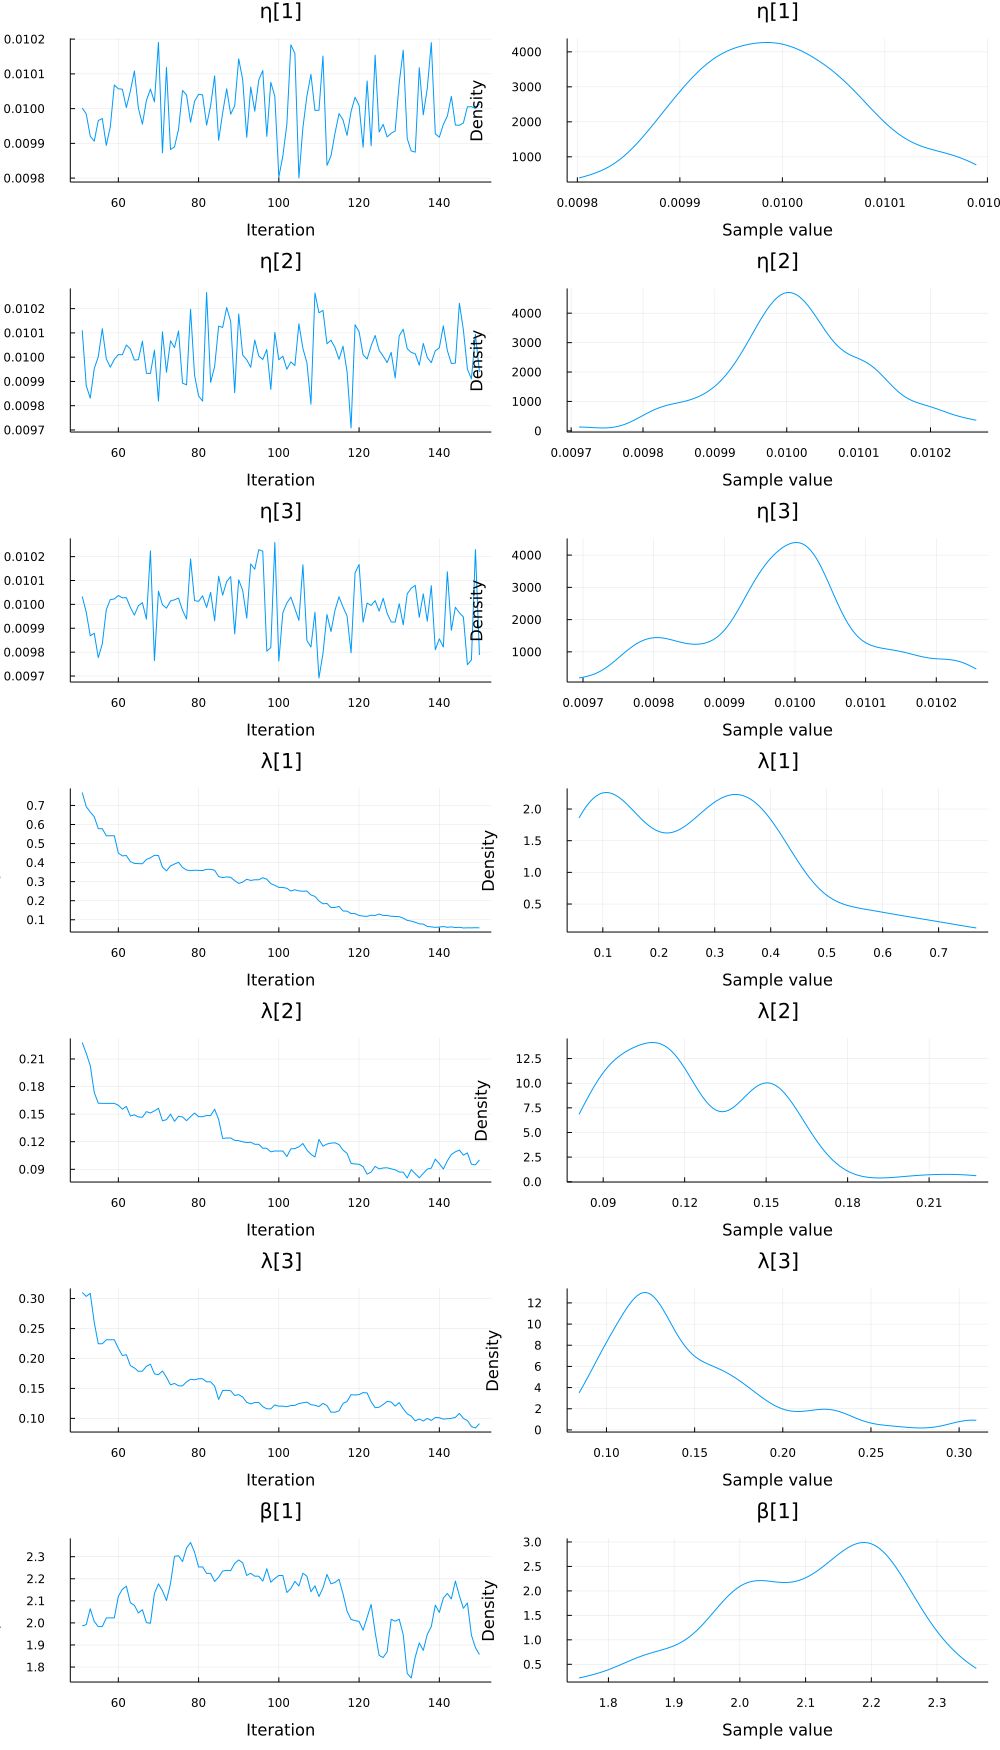

In [223]:
Model = ModelProb(df2[1:50, :], prob, [1, ])
chn = sample(Model, NUTS(), 100)
display(chn)
plot(chn)

In [191]:
length(unique(df2.group))

3

In [187]:
η

3-element Vector{Vector{Float64}}:
 [0.5, 4.0, 13.0, 19.0, 0.1, 3700.0, 1.0e-8, 1.006914078486367, 0.15, 0.5, 0.1, 0.01, 0.01, 1.0e-6, 1.0e-5, 0.5, 0.3]
 [0.5, 4.0, 13.0, 19.0, 0.1, 3700.0, 1.0e-8, 0.9875593753605525, 0.15, 0.5, 0.1, 0.01, 0.01, 1.0e-6, 1.0e-5, 0.5, 0.3]
 [0.5, 4.0, 13.0, 19.0, 0.1, 3700.0, 1.0e-8, 1.0022347435593113, 0.15, 0.5, 0.1, 0.01, 0.01, 1.0e-6, 1.0e-5, 0.5, 0.3]

Example of user-defined loglikelihood

In [205]:
function sir_ode!(du, u, p, t)
    (S, I, R) = u
    (β, γ) = p
    N = S + I + R
    infection = β * I / N * S
    recovery = γ * I
    @inbounds begin
        du[1] = -infection
        du[2] = infection - recovery
        du[3] = recovery
    end
    nothing
end;

In [207]:
using CSV

In [208]:
# Boarding School SIR
boarding_school = CSV.read(download("https://github.com/storopoli/Turing-Workshop/blob/master/data/influenza_england_1978_school.csv?raw=true"), DataFrame);
cases = boarding_school.in_bed;

In [209]:
@model sir(cases, I₀) = begin
  # Calculate number of timepoints
  l = length(cases)
  N = 763
  S₀ = N - I₀
  R₀ = 0

  # Priors
  β ~ TruncatedNormal(2, 1,  1e-6, 10)     # using 10 instead of `Inf` because numerical issues arose
  γ ~ TruncatedNormal(0.4, 0.5,  1e-6, 10) # using 10 instead of `Inf` because numerical issues arose
  ϕ⁻ ~ truncated(Exponential(5), 1, 20)
  ϕ = 1.0 / ϕ⁻

  # ODE Stuff
  u = float.([S₀, I₀, R₀])
  p = [β, γ]
  tspan = (0.0, float(l))
  prob = ODEProblem(sir_ode!,
          u,
          tspan,
          p)
  sol = solve(prob,
              Tsit5(), # You can change the solver (similar to RK45)
              saveat=1.0)
  solᵢ = Array(sol)[2, 2:end] # Infected

  # Likelihood
  for i in 1:l
    solᵢ[i] = max(1e-6, solᵢ[i]) # numerical issues arose
    cases[i] ~ NegativeBinomial(solᵢ[i], ϕ)
  end
end;

In [210]:
sir_chain = sample(sir(cases, 1), NUTS(1_000, 0.65), MCMCThreads(), 2_000, 2);
summarystats(sir_chain[:, 1:2, :]) # only β and γ

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/shigoto/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/shigoto/.julia/packages/Turing/y0DW3/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /home/shigoto/.julia/packages/Turing/y0DW3/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/shigoto/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/shigoto/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

           β    1.8906    0.0984     0.0016    0.0034   633.4680    1.0017     ⋯
           γ    0.8876    0.1561     0.0025    0.0056   628.5250    1.0016     ⋯
                                                                1 column omitted


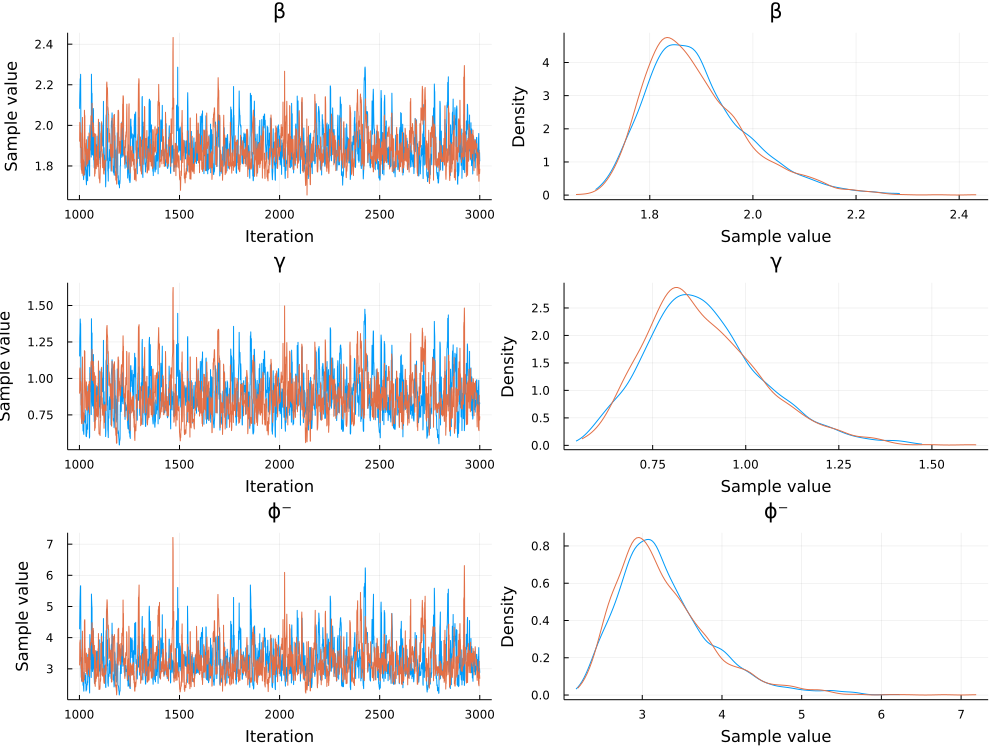

In [211]:
plot(sir_chain)